<h1>kNN Implementation </h1>
<h4> Mike Altschwager </h4>
Outlines a base scikit learn pipeline for using k Nearest Neighbors ratings to determine recommendations for a user. 

Lessons learned:

* Simple poor decisions in matrix management can catch up to you quickly. All my core issues were in processing my results...
* Be VERY positive your profiling you did after making a number of changes still rings true. Kept chasing the knn search function not being performant well after i upgraded the scikit learn libray and was effectively chasing a ghost
* I do feel a little better with various sparse matrix operators vs last lab (mostly due to deconstructing and reconstructing this code hundreds of times trying to figure out why it was slow as hell)
* Still a little unsure why certain trails took WILDLY longer than others (ecludian vs cosign)


In [3]:
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np

<h1> Load Data </h1>

In [4]:
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')

In [5]:
original_movie_ids = set(movies_df["movieId"])
movie_id_map = {original : new for new, original in enumerate(original_movie_ids) }
movies_df["movieId"] = movies_df["movieId"].map(movie_id_map)
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
original_movie_ids = set(ratings_df["movieId"])
movie_id_map = {original : new for new, original in enumerate(original_movie_ids) }
ratings_df["movieId"] = ratings_df["movieId"].map(movie_id_map)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


<h1> Build Raiding Matrix </h1>

In [7]:
# Get the unique user IDs and movie IDs
user_ids = ratings_df['userId'].unique()
movie_ids = ratings_df['movieId'].unique()

# Create a dictionary to map movie IDs to column indices
movie_id_map = {movie_id: i for i, movie_id in enumerate(movie_ids)}

In [8]:
len(movie_ids)

59047

In [9]:

# Initialize lists to store the row indices, column indices, and ratings
row_indices = []
col_indices = []
ratings = []

# Iterate over the ratings dataframe
for _, row in ratings_df.iterrows():
    row_indices.append(int(row['userId']))
    col_indices.append(int(row['movieId']))
    ratings.append(row['rating'])

In [10]:
# Create the sparse spatial matrix
sparse_matrix = csr_matrix((ratings, (row_indices, col_indices)))
sparse_matrix.shape

(162542, 59047)

<h1> Test Train Split</h1>

In [11]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(sparse_matrix, test_size=0.2, train_size=0.8)

Split Test Ratings per User into 80/20% split. We're doing this above the actual training logic so this doesn't have to recompute every time that logic is updated

In [12]:
import numpy as np

# Initialize empty lists to store the row indices, column indices, and values
row_indices_80 = []
col_indices_80 = []
values_80 = []

row_indices_20 = []
col_indices_20 = []
values_20 = []

# Iterate over each row in test_dataset
for row_idx in range(test_dataset.shape[0]):
    # Get the non-zero indices and values for the current row
    non_zero_indices = test_dataset[row_idx].nonzero()[1]
    non_zero_values = test_dataset[row_idx].data
    
    # Calculate the number of non-zero values to include in the 80% matrix
    num_values_80 = int(len(non_zero_values) * 0.8)
    
    # Split the non-zero indices and values into 80% and 20% portions
    indices_80 = np.random.choice(non_zero_indices, size=num_values_80, replace=False)
    indices_20 = np.setdiff1d(non_zero_indices, indices_80)
    
    values_80.extend(non_zero_values[np.isin(non_zero_indices, indices_80)])
    values_20.extend(non_zero_values[np.isin(non_zero_indices, indices_20)])
    
    row_indices_80.extend([row_idx] * len(indices_80))
    row_indices_20.extend([row_idx] * len(indices_20))
    
    col_indices_80.extend(indices_80)
    col_indices_20.extend(indices_20)

# Create the 80% and 20% csc_matrix objects
input_ratings = csr_matrix((values_80, (row_indices_80, col_indices_80)))
test_ratings = csr_matrix((values_20, (row_indices_20, col_indices_20)))

#Need to resize the input_ratings and test_ratings to match the shape of the original test_dataset to fix the columns dropped for having no avg rating (due to no ratings existing period)
input_ratings.resize(test_dataset.shape)
test_ratings.resize(test_dataset.shape)


<h1> Define training function </h1>

In [13]:
import time
from scipy import sparse
from sklearn.base import BaseEstimator
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import vstack
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix

class KNNAverageRatingModel(BaseEstimator): 
    def GetAvgRatings(self, knn_user_ratings_matrix: csr_matrix):
        # Calculate the column-wise average of the sparse matrix
        #print("avging with: ", type(knn_user_ratings_matrix))
        averages = knn_user_ratings_matrix.mean(axis=0)
       
        return averages
    
    def fit(self, training_ratings_matrix: csr_matrix, k, metric, use_tfidf, normalizer):
        self.transformer = TfidfTransformer(norm=normalizer)
        
        self.training_ratings_matrix = self.transformer.fit_transform(training_ratings_matrix) if use_tfidf else training_ratings_matrix # Store the training ratings matrix so we can grab the nearest neighbors later
        self.nn = NearestNeighbors(n_neighbors=k, metric=metric, n_jobs=1)
        self.nn.fit(training_ratings_matrix)
        #print("training model loaded with: ", type(self.training_ratings_matrix))
        
    def predict(self, user_ratings_matrix: csr_matrix, use_tfidf, normalizer): 
        user_matrix = self.transformer.transform(user_ratings_matrix, normalizer) if use_tfidf else user_ratings_matrix 
        neighbors = self.nn.kneighbors(user_matrix)[1] # Get the indices of the nearest neighbors
        
        #print("prediciting with: ", type(self.training_ratings_matrix))
        avg_ratings_list = []
        
        for neighbor_sets in neighbors:
            ratings = self.training_ratings_matrix[neighbor_sets, :]
            avg_ratings_list.append(self.GetAvgRatings(ratings))
        output = np.vstack(avg_ratings_list)
        
        return output
    
    def predict2(self, user_ratings_matrix: csr_matrix, use_tfidf, normalizer): 
        user_matrix = self.transformer.transform(user_ratings_matrix, normalizer) if use_tfidf else user_ratings_matrix    
        neighbors = self.nn.kneighbors(user_matrix)[1] # Get the indices of the nearest neighbors
        
        #print("prediciting with: ", type(self.training_ratings_matrix))
        avg_ratings_list = None
        for neighbor_sets in neighbors:
            ratings = self.training_ratings_matrix[neighbor_sets, :]
            if avg_ratings_list is None:
                avg_ratings_list = self.GetAvgRatings(ratings)
            else:
                avg_ratings_list = np.vstack((avg_ratings_list, self.GetAvgRatings(ratings))) # Fix: Use square brackets to create a list of arrays
        return avg_ratings_list
        
    



<h1>Define Eval Functions </h1>

In [14]:
#load the ratings back into an array in order to compare them
def compare_ratings(predictions: csr_matrix, predictions_array, test_ratings: csr_matrix, test_ratings_array):
    non_zero_indices = test_ratings.nonzero()

    test_ratings_array.extend(test_ratings[non_zero_indices[0], non_zero_indices[1]])
    predictions_array.extend(predictions[non_zero_indices[0], non_zero_indices[1]])
    return test_ratings_array, predictions_array

In [15]:
from numpy import shape

def compute_predictions(avg_rat_model, input_ratings, test_ratings, use_tfidf = False, normalizer = 'l2'):
    test_ratings_array = []
    predictions_array = []
    batch_size = 1000

    for i in range(0, input_ratings.shape[0], batch_size):
        batch_input_og = input_ratings[i:i+batch_size]
        batch_predictions = avg_rat_model.predict(batch_input_og, use_tfidf, normalizer)
        test_ratings_array, predictions_array = compare_ratings(batch_predictions, predictions_array, test_ratings[i:i+batch_size], test_ratings_array)
        #break #this is just to short circuit the loop for testing purposes

    # Replace NaNs that came from dividing by 0 in the fit with 0s, probabbly could do this further up stream, but figured this made the predict loop faster
    predictions_array = np.nan_to_num(predictions_array[0].A1)
    return predictions_array, test_ratings_array[0].A1



In [16]:
from matplotlib import pyplot as plt
import seaborn as sns

def show_box_plot(test_ratings_array, predictions_array):
    # Create a new array to store the rounded predictions
    rounded_predictions_array = np.round(predictions_array * 2) / 2

    # Combine the test_ratings_array and rounded_predictions_array into a DataFrame
    data = pd.DataFrame({'Test Ratings': test_ratings_array, 'Predictions': rounded_predictions_array})

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create a boxplot using seaborn
    sns.boxplot(data=data, x='Test Ratings', y='Predictions', ax=ax)

    # Set the labels for x-axis and y-axis
    ax.set_xlabel('Test Ratings')
    ax.set_ylabel('Predictions')

    # Set the title of the plot
    ax.set_title('Boxplot of Test Ratings vs Predictions')

    # Show the plot
    plt.show()

In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def print_stats(test_ratings_array, predictions_array):

    #Root mean-squared error (RMSE)
    rmse = mean_squared_error(test_ratings_array, predictions_array)
    print('rmse: ', rmse)
    #Pearson's Correlation Coefficient (R2)
    r2 = r2_score(test_ratings_array, predictions_array) 
    print('r2: ', r2)
    #Fraction of user-movie pairs with non-zero predicted ratings
    print('Fraction of user-movie pairs with non-zero predicted ratings ', np.count_nonzero(predictions_array)/len(predictions_array))
    #Fraction of user-movie ratings with a predicted values (recall)
    subtracted_array = np.subtract(predictions_array, test_ratings_array) #zeros mean perfect match
    subtracted_array_rounded = np.round(subtracted_array * 2) / 2 #round to nearest 0.5

    print('Fraction of user-movie pairs with non-zero predicted ratings ', np.count_nonzero(subtracted_array_rounded)/len(subtracted_array))
    #RMSE is appropriate if we want to exactly the predict the ratings of the users.  R2 is useful if we don't care about the ranges of the ratings, just that the predicted ratings rank items in a manner consistent with the user-provided ratings.  The MovieLens ratings are in increments of 0.5.  This makes it easy to visualize the relationships between the user-provided and predicted ratings using a boxplot (user-provided ratings on the X axis, predicted ratings on the Y axis).


<h1> Run Trials </h1>

<H2>Cosine, 5 neighbor<h2>

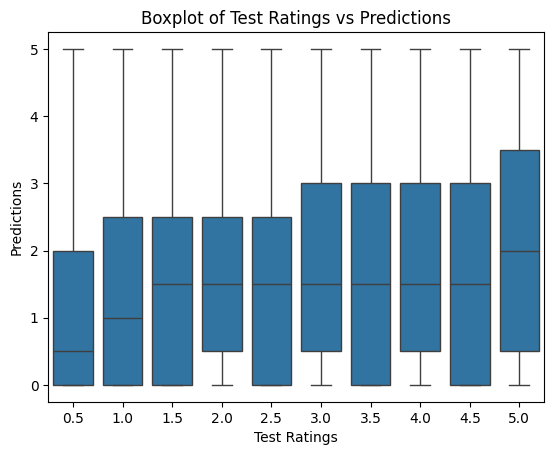

rmse:  6.108925904844813
r2:  -3.985092796866807
Fraction of user-movie pairs with non-zero predicted ratings  0.7608732045401279
Fraction of user-movie pairs with non-zero predicted ratings  0.9200455352060802


In [18]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 5, 'cosine', False, 'l2')

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings)
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)

<H2>Ecludian, 5 neighbor<h2>

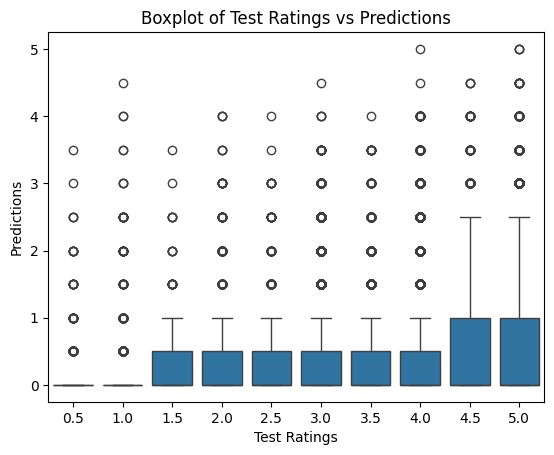

rmse:  11.186795125054408
r2:  -8.128808020687577
Fraction of user-movie pairs with non-zero predicted ratings  0.37509626008638297
Fraction of user-movie pairs with non-zero predicted ratings  0.988582716710751


In [19]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 5, 'euclidean', False, 'l2')

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings)
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)

<H2>Ecludian, 5 neighbor, TDFIF l2<h2>

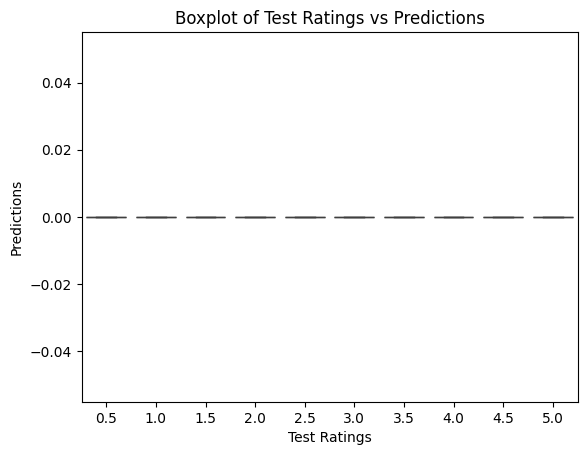

rmse:  13.663414866845478
r2:  -10.149814565486132
Fraction of user-movie pairs with non-zero predicted ratings  0.043593263468041654
Fraction of user-movie pairs with non-zero predicted ratings  1.0


In [20]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 5, 'euclidean', True, 'l2')

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings, True, 'l2')
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)

<H2>Ecludian, 5 neighbor, TDFIF None<h2>

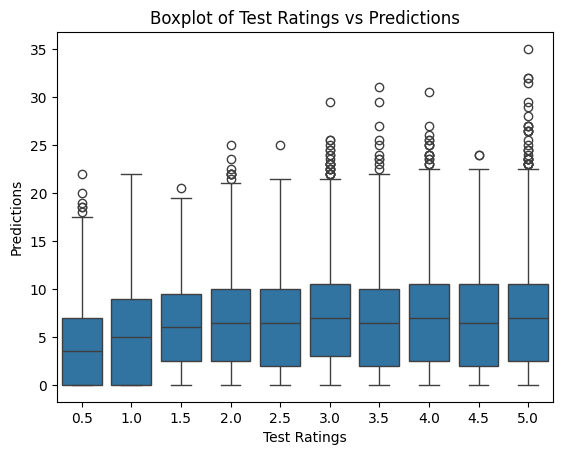

rmse:  37.0612312718906
r2:  -29.24323423369628
Fraction of user-movie pairs with non-zero predicted ratings  0.7951920179462283
Fraction of user-movie pairs with non-zero predicted ratings  0.9735494023504202


In [21]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 5, 'euclidean', True, None)

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings, True, None)
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)

<H2>Cosine, 5 neighbor, TDFIF None<h2>

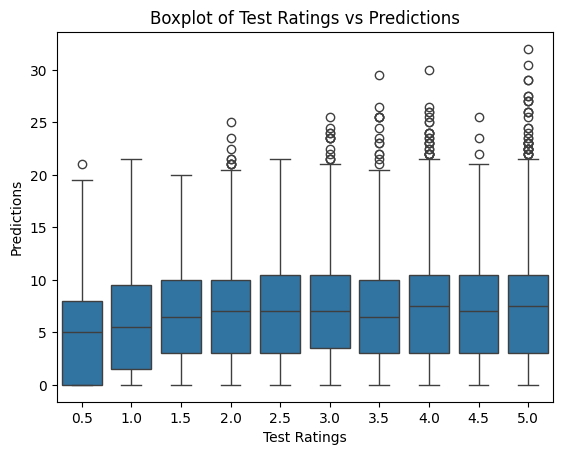

rmse:  36.261085902867535
r2:  -28.590288203953182
Fraction of user-movie pairs with non-zero predicted ratings  0.8270331804332541
Fraction of user-movie pairs with non-zero predicted ratings  0.9732815481970067


In [27]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 5, 'cosine', True, None)

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings, True, None)
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)

<H2>Cosine, 10 neighbor</h2>

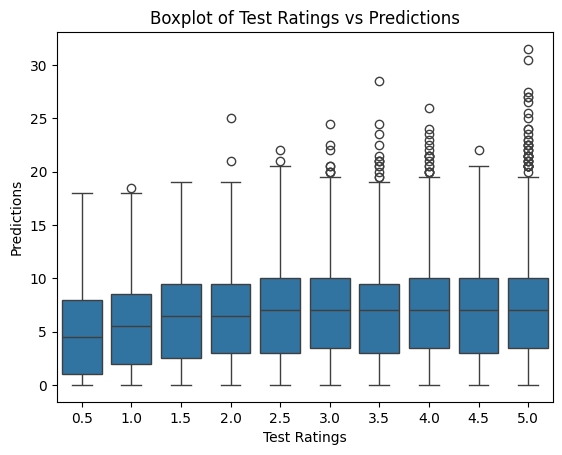

rmse:  30.499368211999915
r2:  -23.888529203153208
Fraction of user-movie pairs with non-zero predicted ratings  0.8917534402517829
Fraction of user-movie pairs with non-zero predicted ratings  0.9714735326614659


In [28]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 10, 'cosine', True, None)

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings, True, None)
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)

<H2>Cosine, 25 neighbor</h2>

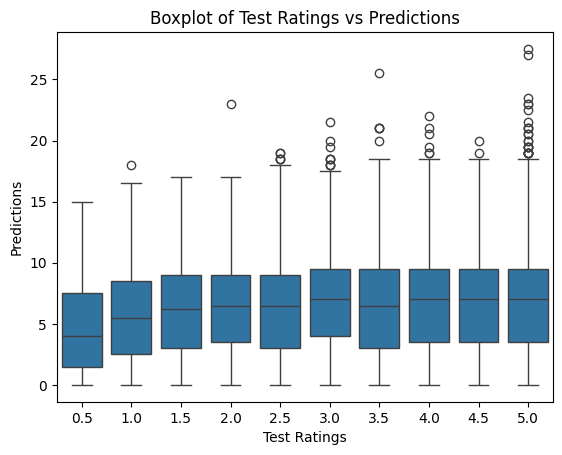

rmse:  25.29137768119613
r2:  -19.63863053264052
Fraction of user-movie pairs with non-zero predicted ratings  0.9421435028626912
Fraction of user-movie pairs with non-zero predicted ratings  0.9669869755917903


In [29]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 25, 'cosine', True, None)

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings, True, None)
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)

<H2>Cosine, 50 neighbor</h2>

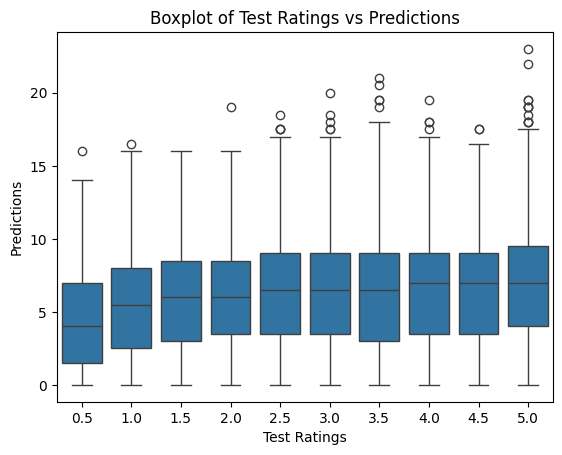

rmse:  22.130086789721926
r2:  -17.058908876597773
Fraction of user-movie pairs with non-zero predicted ratings  0.9659155589781364
Fraction of user-movie pairs with non-zero predicted ratings  0.9634713898282385


In [30]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 50, 'cosine', True, None)

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings, True, None)
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)

<H2>Cosine, 100 neighbor</h2>

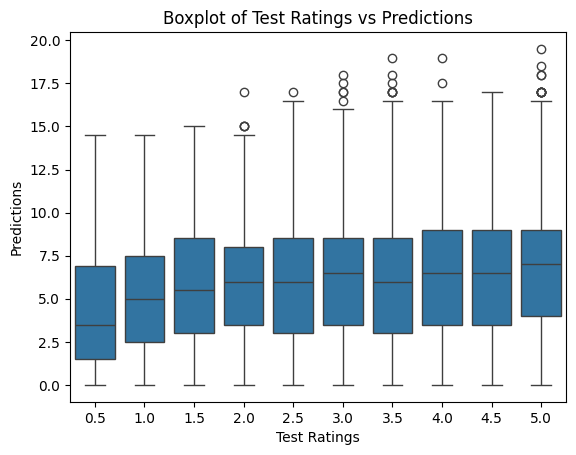

rmse:  19.28141367131263
r2:  -14.734294031957415
Fraction of user-movie pairs with non-zero predicted ratings  0.9792413031104563
Fraction of user-movie pairs with non-zero predicted ratings  0.9626343455988214


In [31]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 100, 'cosine', True, None)

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings, True, None)
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)